#  1/13 spiral undersampling reconstruction using SENSE conjugate gradient

### Using TensorflowMRI and Python 3.12

In [1]:
import json
import sys
import os
import matplotlib.pyplot as plt
import sigpy.mri
import numpy as np
import tensorflow as tf
from time import time
import pynufft
from joblib import Parallel, delayed

sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights
from Tools.reconstruction_utils import NN_prediction

from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks_new import initialize_network
from Neural_Networks.networks_subspace import initialize_network as initialize_AE_network
from CG_SENSE.cg_sense_new_version import reconstruct_lstsq

/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-16 17:56:52.872755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 17:56:52.893288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 17:56:52.899673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 17:56:52.916185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlo

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


## Data loading

In [68]:
#Path to summer and to data
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

#Load brain ROI
roi_brain_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"
path_to_ROI_brain_map = os.path.join(path_to_summer_current, roi_brain_filepath)
ROI_brain, _, _ =  load_acquisition_reconstruction_from_nii(path_to_ROI_brain_map, nb_indents=1, v=False)

#Load k-space from FS cartesian data
Philips_raw_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_FS_ksp_full.npy")
k_space = np.load(Philips_raw_filepath)

#Load coil sensitivity
sens = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_sens.npy")
sensitivity_map = np.load(sens)

#Load Philips reconstruction
Philips_reco_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/reco_FS.npy")
RECO = np.load(Philips_reco_filepath)

#Load Philips spiral trajectory
traj_spirale_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240410_traj_spirale_philips.npy")
traj_spirale = np.load(traj_spirale_filepath)
traj_spirale = traj_spirale[0:2,:]*np.pi / np.max(traj_spirale[0:2,:])

#Load PULSEQ spiral trajectory
traj_spirale_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Lila/spirals/traj_f2_quad_t0_100_int10.npy")
traj_spirale = np.load(traj_spirale_filepath)
traj_spirale = traj_spirale[0:2,:]*np.pi / np.max(traj_spirale[0:2,:])


## Obtain image from the FS k-space and crop data to obtain 192x192 images

In [47]:
image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(k_space, axes = (3,4)), axes = (3,4)), axes = (3,4))

#Crop the first and the last quarters of the image
start_index = int(k_space.shape[4] / 4)
end_index = int(k_space.shape[4] * 3 / 4)

image = image[:,:,:,:, start_index:end_index:1]

In [4]:
sensitivity_map_crop = sensitivity_map[:,:,start_index:end_index]

sensitivity_map_crop = tf.convert_to_tensor(sensitivity_map_crop)

2025-06-16 18:08:54.169890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42400 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5


## Define a spiral with variable density

You can either load a trajectory in .npy with the previous script and go directly to "Generate many spirales", in this case you can pass directly your trajectory to result_nufft function, or you can use the first (homemade) or the second (SigPy) method to generate a trajectory in which case you have to define the parameter and call spiral_variable_density function before using the result_nufft function 

### First method

In [7]:
def spiral_variable_density(alpha, nb_tour, point_per_spiral) : 
    Smax = 500
    gyro_ratio = 2.678*10**8
    Gmax = 0.06

    lambda_ = 192/(2*0.24)
    omega = 2*np.pi*nb_tour

    T_ea = 1 / (gyro_ratio * Gmax * (alpha + 1) / (lambda_*omega))
    T_es = 1 / ((alpha/2 + 1)*np.sqrt((Smax * gyro_ratio)/(lambda_*(omega)**2)))
    T_s2a_denom = lambda_*omega/(alpha/2 + 1) * ((alpha/2 + 1)*np.sqrt(Smax * gyro_ratio/(lambda_*(omega)**2)))**((alpha + 1)/(alpha/2 +1))
    T_s2a_num = Gmax*gyro_ratio
    T_s2a = (T_s2a_num/T_s2a_denom)**((alpha+2)/alpha)
    
    max = T_ea
    if T_es < T_s2a:
        max = T_es
    else:
        if T_s2a > T_ea:
            max = T_s2a

    t = np.arange(0, max, max/point_per_spiral)
    tau = np.zeros_like(t)

    for i, index in enumerate (t):

        if 0<=index<=min(T_s2a, T_es) :
            expo = 1/(alpha/2 +1)
            tau[i] = (np.sqrt(Smax*gyro_ratio/(lambda_ * (omega)**2))* (alpha/2 + 1) * index )**expo

        elif T_s2a<=index<=T_ea:
            expo = 1/(alpha +1)
            tau[i] = (gyro_ratio*Gmax*(alpha+1)*index/(lambda_*omega))**expo


    k_array = np.zeros_like(t, dtype=complex)
    k_array = lambda_ * (tau**alpha) * np.exp(1j * omega * tau)

    k_x = np.real(k_array)
    k_y = np.imag(k_array)

    traj_density_var = np.array([k_x,k_y])

    traj_density_var_norma = traj_density_var*np.pi / np.max(traj_density_var)

    return traj_density_var_norma

In [8]:
spiral_traj = spiral_variable_density(4, 48, 3297)

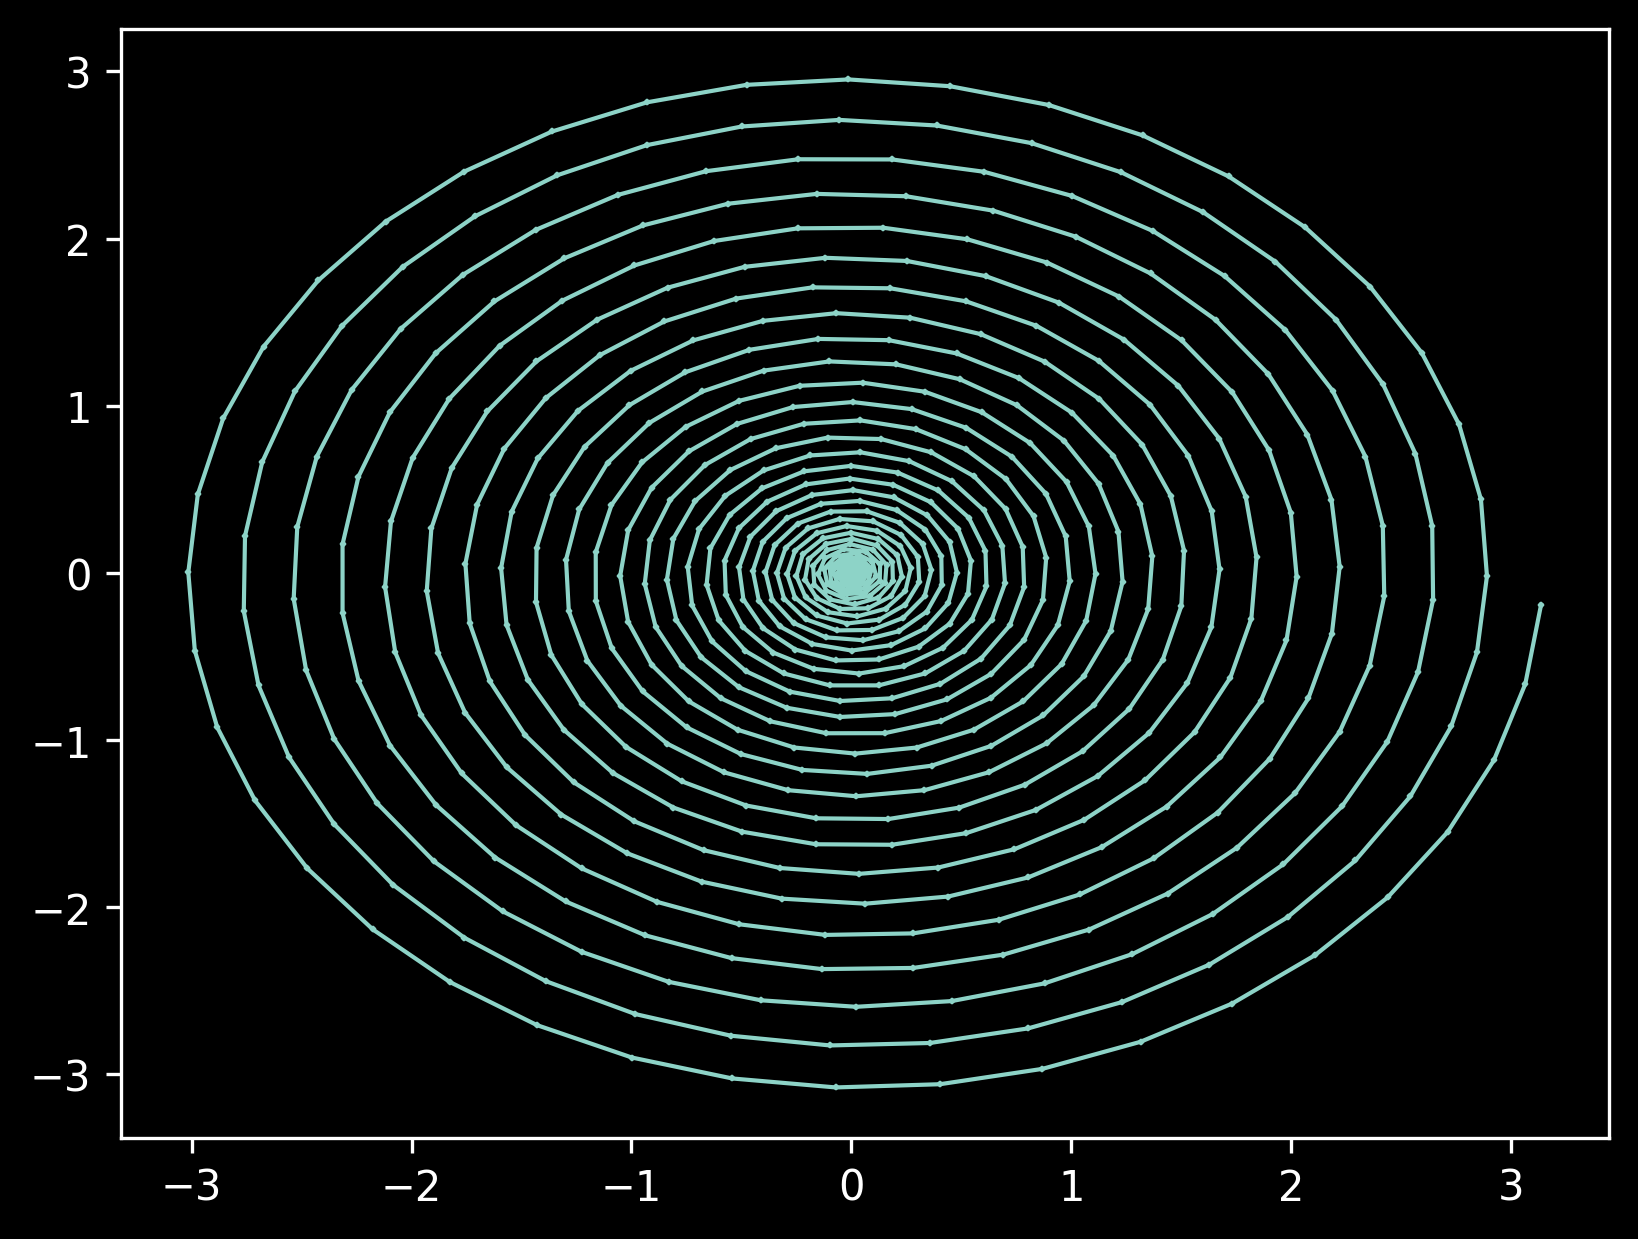

In [9]:
plt.plot(spiral_traj[0,::5], spiral_traj[1,::5], marker='x', markersize=1, linewidth=1)

### Second method (maybe more realistic)

In [ ]:
spiral_traj = sigpy.mri.spiral(fov=0.192, 
              N=192, 
              f_sampling=1, 
              R=12, 
              ninterleaves=1, 
              alpha=4, 
              gm=0.004, 
              sm=200)

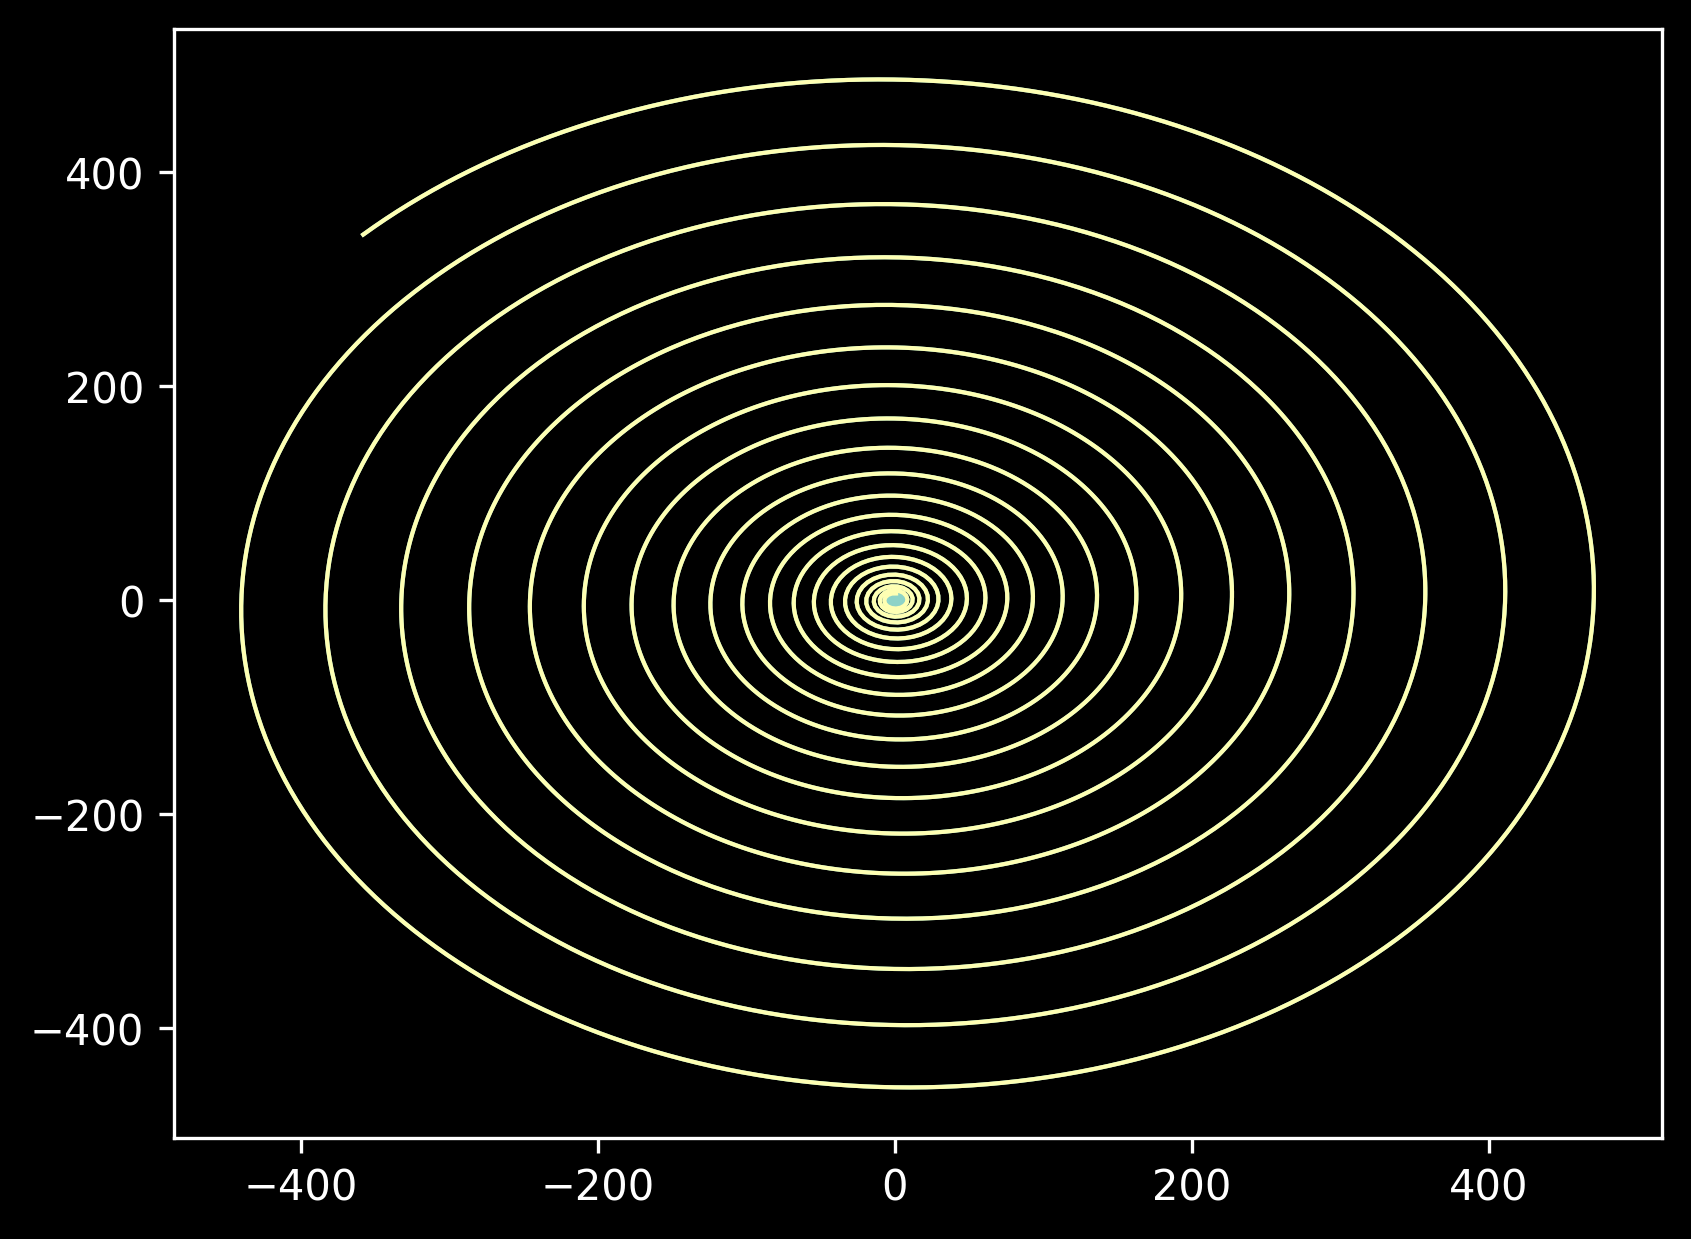

In [12]:
plt.plot(spiral_traj[:,0], spiral_traj[:,1], linewidth=1)

In [23]:
spiral_traj = spiral_traj*np.pi / np.max(spiral_traj)
spiral_traj = spiral_traj.T

### Generate many spirales

In [48]:
def generate_spirale_traj (n_spirale, traj_spirale, theta=0) :
    """
    Apply a rotation to a radial trajectory.

    Args:
        traj_radiale (numpy.ndarray): A 2D array representing the radial trajectory with shape (2, nb_points).
        theta (float, optional): The rotation angle in degrees. Default is 0. The angle is converted to radians.

    Returns:
        numpy.ndarray: The rotated radial trajectory with the same shape as the input `traj_radiale`.
    """
    theta = theta*2*np.pi/360
   
    for i in range(n_spirale) : 
        
        if i ==0:
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c)))

            new_matrix = R@traj_spirale
            conc_trajectory = new_matrix
        
        else:
            angle = theta + i*2*np.pi/n_spirale
            c, s = np.cos(angle), np.sin(angle)
            R = np.array(((c, -s), (s, c)))

            new_matrix = R@traj_spirale
            conc_trajectory = np.concatenate((conc_trajectory, new_matrix), axis=1)
    
    return conc_trajectory

## Use NUFFT to obtain undersampled k-space associated with a spiral trajectory

In [59]:
Nd = (192, 192) #Image size
Kd = (384, 384) #k-space size (2ximage size to avoid aliasing)
Jd = (6, 6) #kernel size

def process_nufft(pulse, traj_spirale_norma, n_spirale, image):
    '''
    Use NUFFT to obtain a non-cartesian undersampled k-space from an image (according to the given trajectory).
    '''
    theta = (pulse * 137.51) % 360 # Increase the angle by 137.51° (the golden angle) between each pulse to induce spiral rotation.
    conc_trajectory = generate_spirale_traj(n_spirale, traj_spirale_norma,theta) #Generate the trajectory
    om = conc_trajectory.T
    
    k_space_nufft = np.zeros((31, om.shape[0]), complex)

    obj_nufft = pynufft.NUFFT()
    obj_nufft.plan(om, Nd, Kd, Jd)

    for coil in range (31):
        k_space_nufft[coil,:] = obj_nufft.forward(image[coil, pulse, 0, :, :]) #Obtain k_space associate to the trajectory and the image by nufft
  
    
    return pulse, k_space_nufft, conc_trajectory.T


def result_nufft(image, n_spirale, traj_spirale_norma):
    '''
    Parallelization of NUFFT functions on all pulses.
    '''
    k_space_nufft_sum =  np.zeros((260, 31, n_spirale * traj_spirale_norma.shape[1]), complex) 
    tot_trajectory = []

    #The function is parallelized on each pulse
    results = Parallel(n_jobs=-1)(delayed(process_nufft)(pulse, traj_spirale_norma, n_spirale, image) for pulse in range(260))  
    
    #The results are stored in k_space_nufft_sum for all pulses and the associated trajectories are stored in tot_trajectory.
    for pulse, k_space_nufft, conc_trajectory in results:
        k_space_nufft_sum[pulse, :, :] = k_space_nufft
        tot_trajectory.append(conc_trajectory)
    
    return k_space_nufft_sum, tot_trajectory

"First case: you use .npy file to define a trajectory"
trajectory = traj_spirale

"Second case: ou use the functions to generate a spiral trajectory"
#Spiral parameters used
n_spirale = 1
alpha = 4
point_per_spiral = 3297
nb_tour = 48
#trajectory = spiral_variable_density(alpha, nb_tour, point_per_spiral)


k_space_nufft_sum, tot_trajectory = result_nufft(image, n_spirale, trajectory)

In [50]:
traj_spirale.shape

(2, 2996)

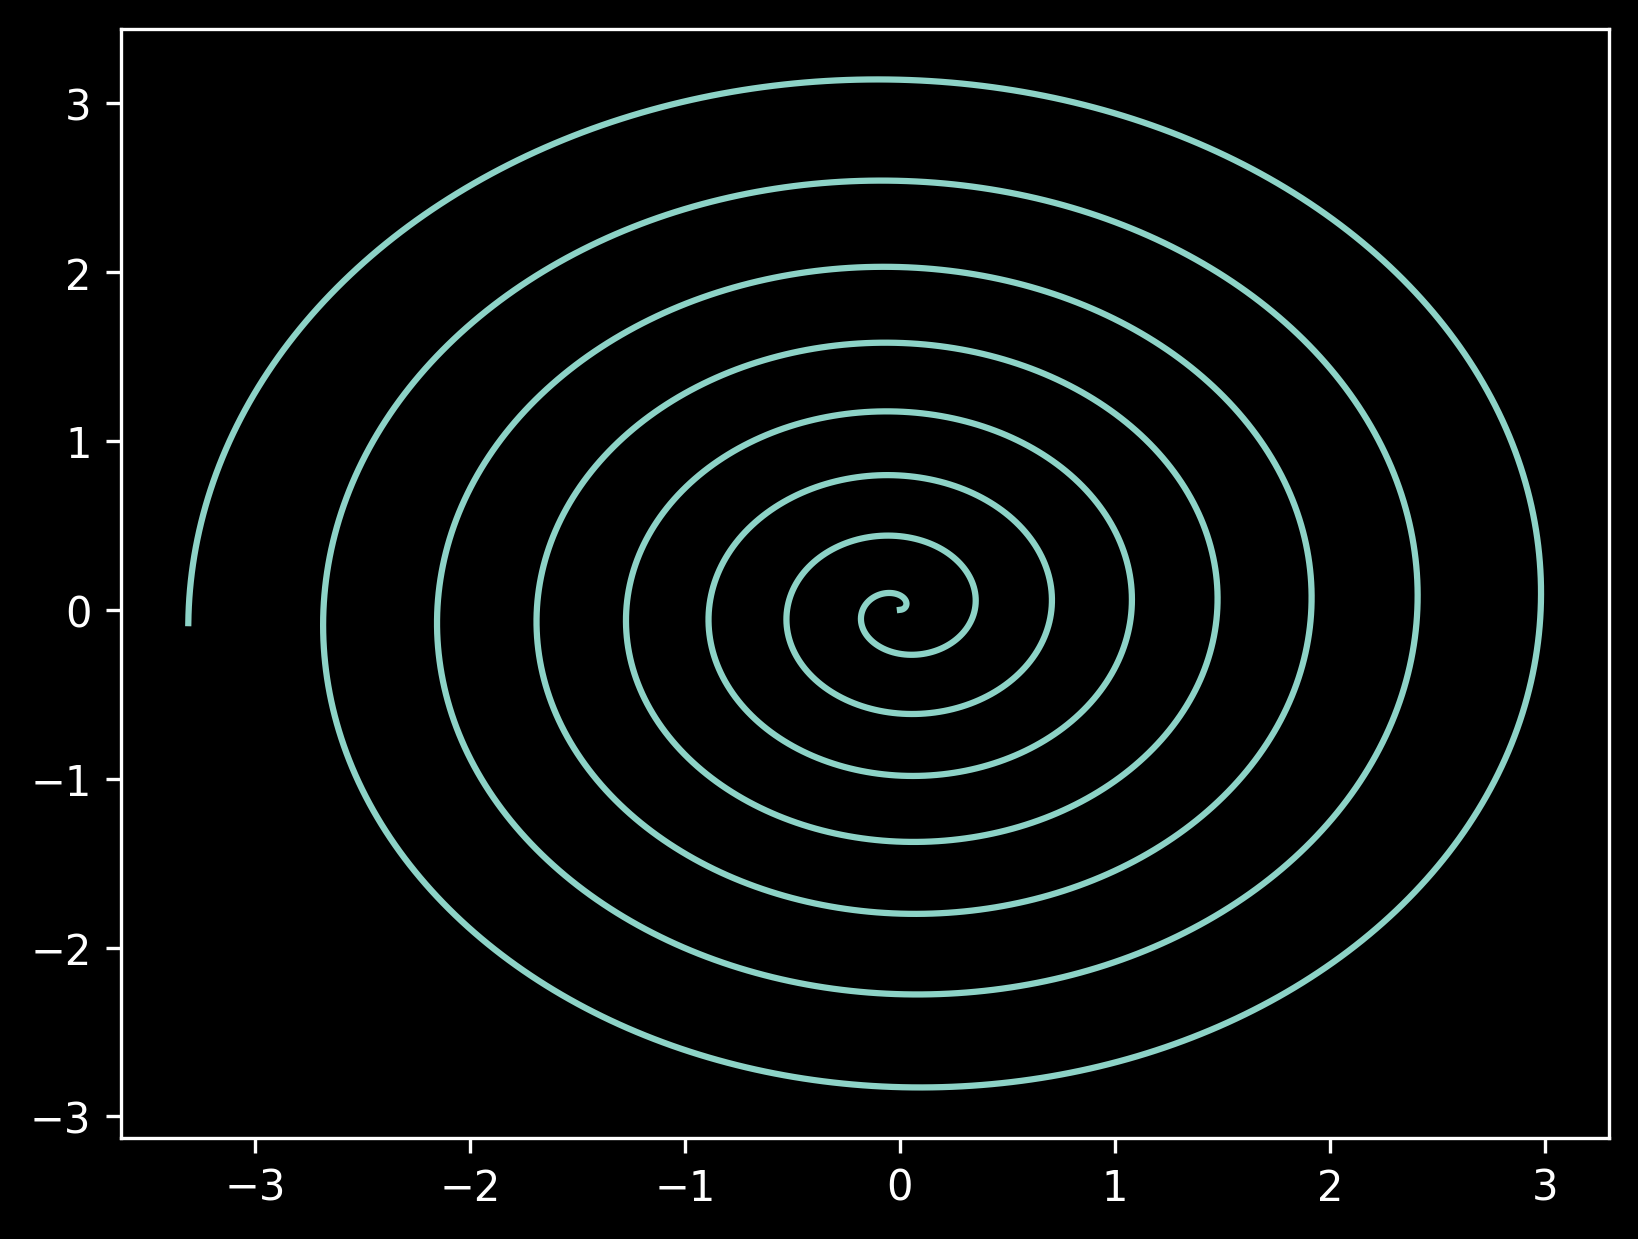

In [75]:
plt.plot(traj_spirale.T[:,0], traj_spirale.T[:,1])

### Checks

In [ ]:
tot_trajectory_arr = np.asarray(tot_trajectory)

In [ ]:
k_space_nufft_sum.shape

In [ ]:
tot_trajectory[0].shape

In [ ]:
plt.imshow(np.abs(k_space_nufft_sum[0:10,0,0:150]))

## Use CG-SENSE to reconstruct the image from the undersampled k-space, trajectory and sensitivity maps

In [76]:
#CG-SENSE is based on tensorflow: convert numpy array to tensor 
tot_trajectory_array = np.array(tot_trajectory)

traj_tf = tf.convert_to_tensor(tot_trajectory_array)
traj_tf = tf.cast(traj_tf, tf.float32)

k_space_tf = tf.convert_to_tensor(k_space_nufft_sum, dtype = tf.complex64)

In [78]:
cg_sense_classic= reconstruct_lstsq(k_space_tf, image_shape=[192,192],extra_shape=260,dynamic_domain='time', trajectory =traj_tf, sensitivities=sensitivity_map_crop, optimizer='cg', optimizer_kwargs={'max_iterations': 60})

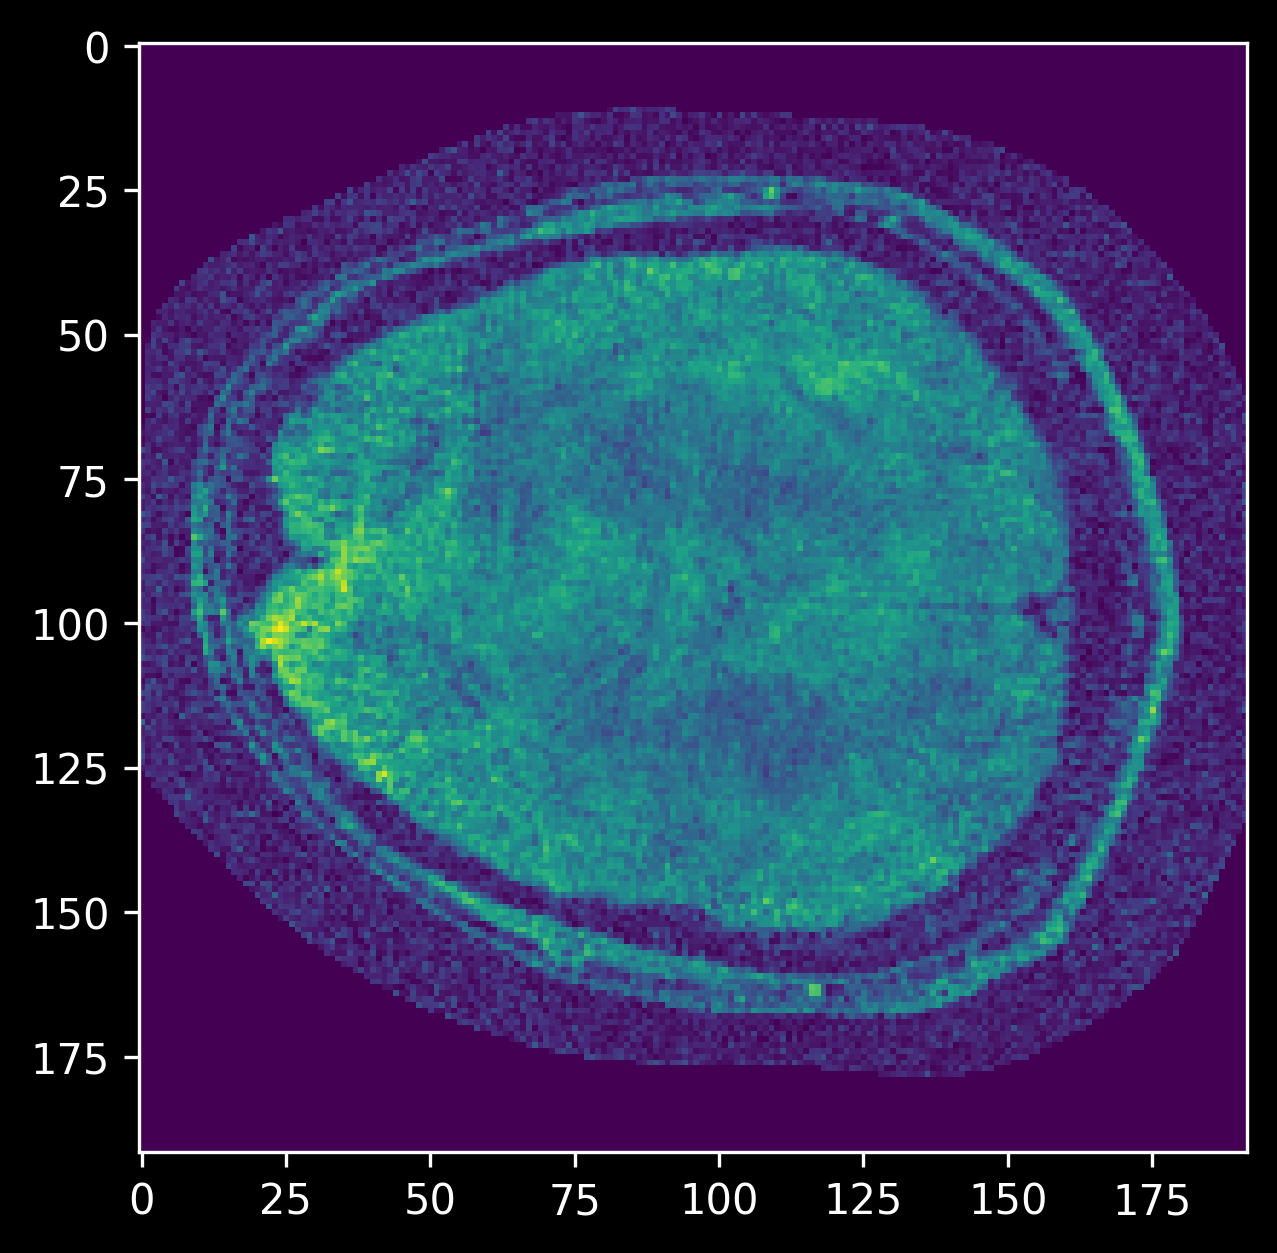

In [77]:
plt.imshow(np.abs(cg_sense_classic[0,:,:]))

## MARVEL reconstructions

In [13]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [14]:
# Initialize the network
n_pulses = 260
n_epochs = 87

start = time()
print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

network_name = "BiLSTM"
input_size = n_pulses 
print(input_size)
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

NN.summary()


INITIALIZE NETWORK
260


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
cg_sense_array = cg_sense_classic.numpy()
cg_sense_array =np.transpose(cg_sense_array, (1,2,0))
cg_sense_array = np.expand_dims(cg_sense_array, 2)

ROI_brain_map_rot = np.rot90(ROI_brain==1)
if ROI_brain_map_rot.ndim == 2:
    ROI_brain_map_rot = ROI_brain_map_rot[:, :, None]

label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']

#Rotation and normalization

RECO_rot = np.rot90(RECO)
RECO_norm = np.abs(RECO_rot)/np.maximum(np.linalg.norm(np.abs(RECO_rot), axis=3)[:, :, :, None], 1e-10)

CG_reconstruction_rot = np.rot90(cg_sense_array,-1)
CG_reconstruction_norm = np.abs(CG_reconstruction_rot)/np.maximum(np.linalg.norm(np.abs(CG_reconstruction_rot), axis=3)[:, :, :, None], 1e-10)

#Predictions

NN_reconstruction_RECO = NN_prediction(NN, RECO_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)
NN_reconstruction_CG = NN_prediction(NN, CG_reconstruction_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


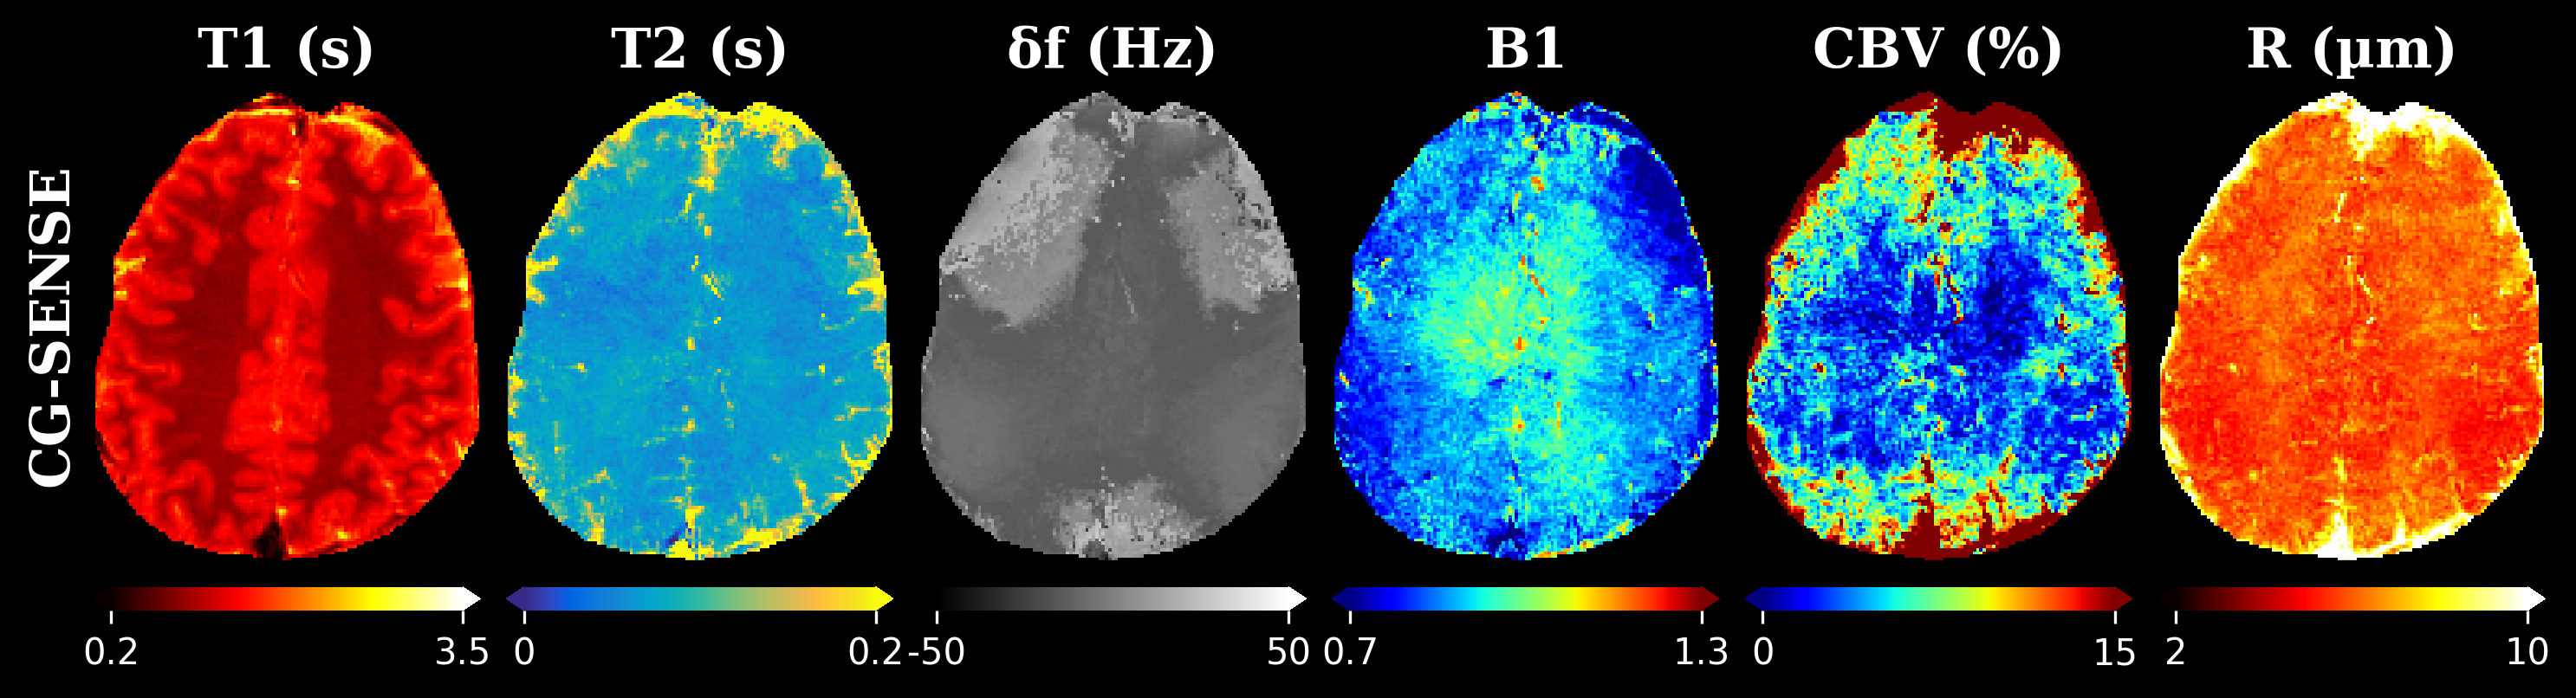

In [74]:
#Plot MARVEL outputs

#fig = plot_parameter_maps(NN_reconstruction_RECO, label_parameters, title='', crop_type='separate', slice_titles = ['RECO'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))
fig = plot_parameter_maps(NN_reconstruction_CG, label_parameters, title='', crop_type='separate',slice_titles = ['CG-SENSE'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))

## TEST : Add AutoEncoder regularization to CG-SENSE

In [13]:
path_to_autoencoder_trainings = "2023_MRF_Collab/Lila/Autoencoder_training/dense_AE/Control_layer_nb"

#name_training = "dim40_continuity0.2"
epoch = 88

AE_training_path = os.path.join(path_to_summer_current, path_to_autoencoder_trainings)

TRAIN_INFOS = json.load(open(os.path.join(AE_training_path, 'training_infos.json')))


print("\nINITIALIZE NETWORK")
NETWORK_INFOS = TRAIN_INFOS["NETWORK_INFOS"]

network_name = NETWORK_INFOS["network_name"]
input_size = 260
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"]
activations = NETWORK_INFOS["activations"]

AE = initialize_AE_network(network_name, layer_shapes, activations)

# Load previous training weights

load_model_weights(AE, layer_shapes, adding_text='_{}epochs'.format(epoch), path_to_model=os.path.join(AE_training_path, "weights"))



INITIALIZE NETWORK
AutoEncoder


In [14]:
class ConvexFunctionAERegularization(convex_ops.ConvexFunction):
    def __init__(self,
                 domain_dimension=None,
                 scale=None,
                 dtype=tf.complex64,
                 name=None):

        super().__init__(domain_dimension=domain_dimension, scale=scale, dtype=dtype, name=name)

    def _call(self, x):
        
        x_reshape = tf.reshape(x, (260, 192 * 192))
        x_t = tf.transpose(x_reshape)
        
        # Détection des colonnes nulles
        col_norms = tf.norm(x_t, axis=1)
        mask = tf.abs(col_norms) > 0 # True si la colonne n'est pas nulle

        # Sélection des colonnes non nulles
        x_nonzero = tf.boolean_mask(x_t, mask, axis=0)
        
        is_empty = tf.equal(tf.size(x_nonzero), 0)

        def predict_fn(x):
            return tf.complex(AE.predict(x),tf.zeros_like(x))
        
        def return_zero_matrix():
            return tf.zeros((192, 192), dtype=tf.float32)

        def process_matrix():
            # Normalisation en batch
            x_normalized = x_nonzero / tf.norm(x_nonzero, axis=1, keepdims=True)
            print(x_normalized.dtype)
            # Reconstruction avec l'autoencodeur
            y_pred = tf.numpy_function(predict_fn, [tf.abs(x_normalized)], tf.complex64)
            
            y_reconstructed = tf.scatter_nd(tf.where(mask), y_pred, tf.shape(x_t, out_type=tf.int64))
            x_reconstructed = tf.scatter_nd(tf.where(mask), x_normalized, tf.shape(x_t, out_type=tf.int64))
 
            # Calcul de la différence pixel par pixel et reshape en 192x192
            diff = tf.reduce_sum(tf.math.abs(tf.norm(y_reconstructed - x_reconstructed, ord=2)))
            
            return self._scale * diff
        
        output = tf.cond(is_empty, return_zero_matrix, process_matrix)
        return output

    def _prox(self, x, tau):
        print('Use proximal operator')
        return x


In [15]:
regul = ConvexFunctionAERegularization(domain_dimension=192*192*260, scale=0.01)

In [16]:
cg_sense= reconstruct_lstsq(k_space_tf, image_shape=[192,192],extra_shape=260,dynamic_domain='time', trajectory =traj_tf, regularizer=regul, sensitivities=sensitivity_map_crop, optimizer='lbfgs', optimizer_kwargs={'max_iterations': 60})

Instructions for updating:
Use fn_output_signature instead


2025-03-20 18:47:52.933252: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


lbfgs minimization
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Regularization start
Tensor("value_and_gradient/Abs:0", shape=(), dtype=float32)
()
<dtype: 'complex64'>
Regularization has been done


I0000 00:00:1742492875.593855  835818 service.cc:146] XLA service 0x7f8260077a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742492875.593894  835818 service.cc:154]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2025-03-20 18:47:55.644134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


206/861 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step

I0000 00:00:1742492877.974772  835818 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 792us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 781us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 777us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
861/